<a href="https://colab.research.google.com/github/t-tsue/public/blob/main/PBL02_sample_code_effb6_entropy_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PBL_02 不良箇所自動検出 良否判定モデル構築用サンプルコード

このコードはGoogle Colaboratory用に作成しています。

当サンプルコードは、PBL02のデジタル課題（演習03）において、課題「出荷検査工程のコスト・負荷がかかり、検品精度にばらつきがある」に対し、出荷検査工程の画像AIモデルの構築と精度検証を目的としたものです。検証の方法論の足掛かりとしてご利用ください。当サンプルコードは以下の流れで構成されています。

1. [Googleドライブと接続](#1)</li>
    Googleドライブとサンプルコードを接続する。
1. [ライブラリimport](#2)</li>
    必要なライブラリのimportを行う。
1. [パラメータ設定](#3)</li>
    画像分類アルゴリズム"VGG"に関する設定とデータ、ウェイトのパス設定を行う。
1. [VGGのネットワーク定義](#4)</li>
    VGGのネットワークを本課題向けにカスタマイズし、カスタマイズしたVGGを宣言する。<br>
    具体的には、VGGの基本設定、事前重み有無設定、出力層のカスタマイズを行う。
1. [学習・検証データの読み込み](#5)</li>
    3. で指定した格納先の学習・検証データを読み込む。
1. [モデルの学習](#6)</li>
    読み込んだデータを用いてVGGを学習させる。
1. [モデルによる判定](#7)</li>
    構築したモデルによる判定を実施する。
1. [学習・検証データに対する精度評価](#8)</li>
    学習・検証データに対する精度をF1-score、Precision、Recallで評価します
1. [提出ファイルの出力](#9)</li>
    テストデータに対して良否判定を行い、その結果を提出フォーマットであるtsv形式で出力を行う。
</ol>



使用するデータは以下です。

- train_master.tsv
- sample_submit.tsv
- train フォルダ内の画像データ
- test  フォルダ内の画像データ

学習ポータル（moodle）からダウンロードし、Google Driveの直下に「DXQuest_PBL02」というフォルダを作成いただき、当該フォルダ内に当ノートブックおよび上記ファイルを配置してください。なお、以下のようなフォルダ構成を前提としています。

```
DXQuest_PBL02
│  PBL02_sample_code.ipynb
│  requirements.txt
│  参考) データ説明.txt
│  train_master.tsv
│  sample_submit.tsv
│
└─train
│   └─regular
│   │      regular_000.jpeg~regular_099
│   │  
│   └─potato
│   │      potato_000.jpeg~potato_102.jpeg
│   │  
│   └─horn
│   │      horn_000.jpeg~horn_056.jpeg
│   │  
│   └─bridge
│          bridge_000.jpeg~bridge_029.jpeg
│  
└─test
│    000.jpeg ~ 212.jpeg
│
└─weights

```

⭐️初学者の方へ<br>
わからない単語やエラーメッセージが出た際は、積極的に生成AIを活用してみましょう。

生成AI活用ガイド
https://lifeistech.notion.site/AI-0dc27ac2252342598a46b6948ff2e683?pvs=74

# 1. Googleドライブと接続
学習データなどを読み込めるようにするため、Googleドライブとサンプルコードを接続します。

In [1]:
# Google Driveに接続できるdriveというモジュールをgoogle.colabというライブラリからインポートする。
from google.colab import drive

# Google Driveにマウント（接続）する。これにより、Colab上でGoogle Drive内のファイルにアクセスできるようになる。
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


⭐️初学者向け解説
<br>
```
パッケージ：Pythonにおける「パッケージ」とは、便利なツールの詰め合わせのようなものです。Pythonにはたくさんの機能があって、例えば
数学の計算やデータの扱い、グラフを描くことなどができます。でも、そのすべての機能を最初から使うのは難しいので、必要な機能だけを
まとめて持ってくる方法がパッケージです。

このパッケージを使うためには、まずはpipというコマンドを実行することで、必要なパッケージをインストールします。
pipを使うと、Pythonパッケージを簡単にインストールしたり、
アンインストールしたり、アップデートすることができます。

!pip install パッケージ名

でインストールします。
```
</br>

In [2]:
# 各パッケージの名前とバージョンを設定
packages = {
    "Keras": "2.15.0",
    "tensorflow": "2.15.0"
}

# 各パッケージをインストール（依存関係を無視）
for package, version in packages.items():
    try:
        # パッケージをインストール
        !pip install {package}=={version} --no-deps -q
        # うまく行ったらInstalledと表示
        print(f"Installed {package}=={version}")
    except:
        # 失敗すればFailedと表示
        print(f"Failed to install {package}=={version}")

Installed Keras==2.15.0
Installed tensorflow==2.15.0


---
#####Google Driveと接続した上で、必要なパッケージも揃い、環境が用意できました。次のセクションに進みましょう。
---

## 2. ライブラリimport
本サンプルコードで使用するライブラリのバージョンを指定します。<br>
便利なプログラムをひとまとめにし、誰でも使いやすい状態にしたものを"ライブラリ"と読んでいます。<br>
本サンプルコードでは、いくつかの"ライブラリ"を使用するため、使用するライブラリが何かをこちらで宣言（import ~~）しています。<br>
宣言することでgoogle colaboratoryはどのライブラリを使用するのか認識し、ライブラリのプログラムを使用できるようになります。<br>

⭐️初学者向け解説（import）
```
Pythonにおけるimportとはパッケージを持ってきて使うためのコマンドです。

from ~ import ~は、特定のパッケージから、必要な関数などを取り込むための文です。
これを使うと、パッケージ全体ではなく、必要な部分だけを使うことができ、コードをすっきりさせるのに役立ちます。

たとえば、
from tensorflow import keras
は、tensorflowというパッケージからkerasというモジュール（特定の機能や役割をもったプログラムをまとめたもの）を
インポートするという意味です。
```


In [3]:
# 今回使うライブラリをインポートする
import os #ファイルの操作ができるライブラリ
import glob
import cv2 #画像処理をするライブラリ
import numpy as np #大量の数字の計算が高速にできるライブラリをnpとしてインポートする
import pandas as pd #表形式のデータを扱うためのライブラリをpdとしてインポートする
import matplotlib.pyplot as plt #グラフを描画するためのライブラリをpltとしてインポートする
from PIL import Image #画像処理のためのライブラリPILから画像の読み込みや保存をするImageモジュールをインポートする
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
) #評価指標を計算するためのライブラリsklearn.metricsから、使用する評価指標の計算モジュールをインポートする

# 機械学習のためのツールをインポートする
import tensorflow as tf # TensorFlowはAIや機械学習のモデルを作るためのライブラリ
from tensorflow import keras # KerasはTensorFlowの中で、簡単にモデルを作るためのモジュール
from keras import optimizers # モデルの学習を助ける最適化アルゴリズム（効率的に学習を進めるやり方）を提供するモジュールをインポートする
from keras.preprocessing.image import ImageDataGenerator # 画像データの前処理や水増し（データオーギュメンテーション）を行うモジュールをインポートする
from keras.models import Sequential, Model # ニューラルネットワークモデルを作るための基本的なツールをインポートする
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input # 画像データの学習に欠かせない処理（畳み込み層やプーリング層）を作るモジュールをインポートする
from keras.layers import Activation, Dropout, Flatten, Dense # 画像データの学習に欠かせない処理（活性化関数やドロップアウト層、全結合層など）を追加するためのモジュールをインポートする
from keras import backend as K # Kerasが裏で使っている仕組みにアクセスし、高度な設定やカスタマイズを行うためのモジュールをインポートする
from sklearn.model_selection import StratifiedKFold
# from tensorflow.keras.utils import np_utils # クラスの名前を数字のリストに変えるためのモジュールをインポートする
from keras.applications.vgg16 import VGG16 # 事前に学習されたVGG16モデルをインポートし、それを使って学習を進める（転移学習）
from keras.applications import EfficientNetB6 # 事前に学習されたEFFB6モデルをインポートし、それを使って学習を進める（転移学習）
tf.random.set_seed(1) # 実験の結果が毎回同じになるようにする（乱数シードを固定する）
plt.style.use('ggplot') # グラフのスタイルを「ggplot」に設定して、視覚的に見やすくする

---
#####今回使用するライブラリをインポートしました。これにより、ファイルの操作、画像処理、数値計算、データの可視化、機械学習モデルの構築と評価など、さまざまな作業を行う準備が整いました。<br>また、TensorFlowとKerasというライブラリをインポートしたことで、機械学習モデルを簡単に構築・学習できる環境も設定されました。次のセクションに進みましょう。
---

## 3. パラメータ設定
画像分類アルゴリズム"VGG"に関する設定とデータ・ウェイトのパス設定を行います。<br>

⭐️初学者向け解説（アルゴリズム / パラメータ）
```
アルゴリズムとは、コンピュータがデータからパターンを学んで、新しいデータに対して予測や判断を行うための「ルール」や「計算の手順」のことです。
パラメータとは、モデルがデータから学習するための「ルール」や「パターン」を表す値と考えてください。
ここでは、入力画像サイズや判定分類数、エポック数、バッチサイズを指定しています。
```

⭐️初学者向け解説（エポック数 / バッチサイズ）
```
エポック数とバッチサイズは、機械学習、特にディープラーニングで使われる言葉です。
エポック数は、データを使ってモデルが学習をする回数のことです。
バッチサイズは、一度に学習させるデータの量のことです。

＜エポック数とバッチサイズの関係＞
問題集を解くことに例えると、エポック数は、全部の問題集を何回解くかという「全体の学習回数」。
バッチサイズは、一度に解く問題の量という「分けて解く量」。
例えば、問題集が100問あり、バッチサイズが10なら、1エポック（問題集全体を1周）には10回の学習ステップが必要です。
エポック数が2なら、全体で20回の学習を行います。
```

⭐️初学者向け解説（VGG16）
```
VGG16は、画像の特徴を何層にも分けて分析し、最終的に「この画像は何か？」を判断するための計算の流れ（ネットワーク）です。
最初の方では、画像の細かい特徴（色や線）を見つけ、次第にその特徴を組み合わせて、最終的に「これは猫だ」「これは車だ」と判断します。
たくさんの「パラメータ」（学習する情報）を使って、コンピュータは正確に物体を見分けることができるようになります。

例えば、block1_conv1という名前の層は、VGG16の最初のブロックの中で最初に出てくる畳み込み層です。
このように、VGG16は5つのブロックに分かれていて、それぞれが画像を段階的に処理していきます。

畳み込み層は、画像の特徴（色や形、線など）を見つける場所です。
モデルには、たくさんの畳み込み層があり、それぞれが画像の違った特徴を学びます。たとえば、最初の畳み込み層では、
画像の基本的な輪郭を探し、次の層ではもっと細かい部分（耳や目の形など）を探します。
```

In [4]:
# 画像分類アルゴリズム"VGG"に関する設定をする
# 入力画像サイズの高さと幅（サイズを大きくするとより画像の特徴が明らかになり、特徴を学習しやすくなる可能性がある。しかし、学習に要する時間が増えてしまう。
IMG_WIDTH, IMG_HEIGHT = 528, 528
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# 判定分類数（4分類を判定するモデルを構築し、その4つの判別結果を最後に良品、不良品の2分類に変換する前提）
NB_CLASSES = 4

# 学習時のエポック数
# （学習データを何回学習させるかのパラメータ。回数を増やすとその分モデルは学習データの特徴を学習できる
# ただし、学習用データに過度に適合しテスト用データには適合しないモデルになる可能性がある。）
EPOCHS = 50

# バッチサイズ
# （一度の学習で何枚の画像データを使用するかというパラメータ。100枚の学習データがあった際にバッチサイズを5とすると、5枚ずつ20回学習することを意味する。
# ここで言う"一度の学習"とは、VGGモデルを更新するタイミングのことを言う。バッチサイズ5のときは、5枚のデータ毎に更新されることになる。）
BATCH_SIZE = 8

---
#####画像分類アルゴリズムの準備として、モデルの学習に必要な設定を行いました。<br>画像サイズや分類数、学習の回数（エポック数）、一度に処理するデータの量（バッチサイズ）を指定し、<br>モデルが学習する際の基本条件を決めました。<br>これらの設定により、画像を効率よく処理し、適切に学習できるようにするための土台が整いました。
---

🔔初学者向け次のコードの解説
```
画像データがどういう順番で保存されているかを確認しています。
channels_firstなら、色が最初に来る → (3, 横幅, 縦幅)
channels_lastなら、色が最後に来る → (横幅, 縦幅, 3)
この違いを正しく判定することで、画像データを正しい形で機械学習モデルに入力できるようにしています。
このコードは、画像を使ってAIモデルを作るときに、画像データがどういう形式で保存されているかに応じて、適切な形を決めるために必要です。
```

In [5]:
# データの形を判定する（色のデータが最初か最後か判定している）
if K.image_data_format() == 'channels_first':
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [6]:
# 学習データ保存場所のパスを格納する。bridge, horn, potato, regularのフォルダがあり、各フォルダの中に画像が格納されている想定
train_data_dir = '/content/drive/MyDrive/DXQuest_PBL02/train_conv'

# 検証用データ保存場所のパスを格納する。bridge, horn, potato, regularのフォルダがあり、各フォルダの中に画像が格納されている想定
# 本サンプルコードでは、簡便さを重視し、検証用データも学習データと同じものを使用。通常、学習と検証用のデータは任意の割合で分割する
validation_data_dir = '/content/drive/MyDrive/DXQuest_PBL02/train_conv'

# テストデータ保存場所のパスを格納する。画像データが格納されている想定
test_data_dir = '/content/drive/MyDrive/DXQuest_PBL02/test_conv'

# 画像分類アルゴリズムのweightファイル保存場所のパスを格納する
# モデルの「重み（weight）」とは、モデルが学習を通じて得たパラメータのこと。例えば、画像を「猫」と「犬」に分類するモデルがあったとすると、
# 学習を通じて「耳の形」「毛の質感」などの特徴に基づいて分類するルールを学習し、そのルールが重みとして保存される。
# これらの重みを保存することで、後でモデルを再利用したり、学習を続けることができる。
weight_dir = '/content/drive/MyDrive/DXQuest_PBL02/weights'

# weightファイルの名前
save_weights_path = os.path.join(weight_dir, 'weights.weights_effb6.h5') # 'weights.h5'のファイル名は変更可

In [7]:
train_files = sorted(glob.glob(os.path.join(train_data_dir, '*/*.jpeg')))
test_files = sorted(glob.glob(os.path.join(test_data_dir, '*.jpeg')))

train_df = pd.DataFrame({'x': train_files})
test_df = pd.DataFrame({'x': test_files})
train_df['y'] = train_df['x'].apply(lambda x: x.split('/')[-2])

---
#####画像データの形式を確認し、学習や検証、テスト用のデータ保存場所を設定しました。また、モデルの重みを保存する場所も指定しました。<br>これにより、モデルの学習や評価に必要なデータの準備と、学習結果の保存が可能になりました。
---

## 4. VGGのネットワーク定義
VGGのネットワークを本課題向けにカスタマイズします。<br>
具体的には、VGGの基本設定と事前重みの設定（以下「weights='imagenet'」がこれに相当）、出力層のカスタマイズなどを行います。<br>
事前重みの設定とは、あらかじめ様々なデータでVGGを学習させて見つけ出した良いパラメータ値をパラメータの初期値として設定することを意味します。これにより、始めからある程度汎用性のあるモデルになります。
更に、今回のデータでこのモデルを学習させることで学習速度を速め、かつ安定したモデルにすることを目指します。<br>

⭐️初学者向け解説（ネットワーク）
```
「ネットワーク」という言葉は、コンピュータがデータを処理するための計算の流れや構造を指しています。VGGでは、画像を何段階にも分けて処理し、
最終的にその画像が何かを判断する流れが「ネットワーク」です。

VGGネットワークを例えると…
VGGネットワークを人間の目に例えると、次のような流れです：

最初に画像をざっくり見る（「これは何かの写真だな」）。
細かい部分を見て特徴を確認する（「これは耳だ」「これは四角い形だ」）。
全体を見て判断する（「耳があるし、丸い形があるから、これは猫だ！」）。
コンピュータはこの「画像を見て特徴を見つける」という流れを、VGGネットワークの層を使って行っているのです。

つまり、VGGのネットワークは、コンピュータが画像の中から特徴を見つけて、それが何かを判断するための「層を積み重ねた計算の仕組み」です。
```


🔔初学者向け次のコードの解説
```
VGG16モデルを設定して、事前に学習された知識を使って画像を分類する準備をしています。
・ImageNetで学習された重みを使うことで、モデルはすでに基本的な画像分類ができるようになっています。
ImageNetとは、何百万枚もの画像が入ったデータベースで、いろいろな物体（犬、車、花など）を識別できるようにモデルが事前に学習されています。
つまり、今回のVGG16はすでに学習された知識を使って画像を分類することを示しています・
・include_top=Falseで、モデルの最後の分類部分を外し、自分の用途に合わせてカスタマイズできるようにしています。
・画像のサイズを「224×224ピクセルのRGB画像」として設定しています。
```

In [8]:
# VGG16という画像分類アルゴリズムの基本モデルの初期設定をする
base_model = EfficientNetB6(
    # 学習済みの重みを利用する。'imagenet'は、画像データベースImageNetで事前に学習された重みを使う設定。
    weights='imagenet',

    # モデルの最上位の全結合層（分類を行う部分）を除外する設定。この後、自分で分類層を追加してカスタマイズするために使う。
    include_top=False,

    # モデルの入力サイズを指定する。ここでは、224x224ピクセルのRGB画像を入力として受け取るように設定している。
    input_tensor=Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
)

🔔初学者向け次のコードの解説
```
summary() の結果を見ると、各レイヤーの形状（サイズやパラメータ数）と順序が確認できます。
各層の出力サイズや学習可能なパラメータ数も表示され、モデルの全体像が把握できます。

畳み込み層（Conv2D）で画像から特徴を抽出し、プーリング層（MaxPooling2D）で画像を圧縮して、特徴を少しずつ絞り込んでいきます。
VGG16には、約1470万個のパラメータがあり、それを使って画像を分類する方法を学びます。
データの形は、処理が進むにつれてどんどん小さくなり、最終的には小さな特徴の集まりに変わります。
簡単に言うと、VGG16は、画像をたくさんの層で処理しながら、少しずつ「これは何か？」を理解していくモデルです。
```

In [9]:
# ネットワーク構造の確認
base_model.summary()

Model: "efficientnetb6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 528, 528, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 528, 528, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 528, 528, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 528, 528, 3)          0         ['normalization[0


🔔初学者向け次のコードの解説
```
このコードでは、以下のように画像分類モデルの出力部分をカスタマイズして、特定の課題に合った予測ができるように変更する作業です。
ここでは、既存のVGG16というモデルに新しい「出力層」を追加して、自分が分類したいクラス（4種類など）に合わせて、
最終的な予測を行う部分を作っています。

・VGG16の出力を1列に並べる：まず、画像データを計算しやすい形（1次元）に変換します。
・新しい層を追加：512個のノード（計算するパーツ）を持つ層を追加し、ReLUという方法でデータを整理します。
・過学習を防ぐためのDropout：50%のノードをランダムに無効にして、学習しすぎを防ぎます。
・最終的な出力層を作成：4つのクラスに分類するための出力層を追加し、各クラスの確率を計算します。
```

In [10]:
# 出力層のカスタマイズ（出力に近い層を本課題に合わせて変更）
# ベースモデルの出力を取得する。ここから出力層をカスタマイズする処理を開始する。
top_model = base_model.output

top_model = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(top_model)
top_model = tf.keras.layers.BatchNormalization()(top_model)

top_dropout_rate = 0.2
top_model = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(top_model)
top_model = tf.keras.layers.Dense(NB_CLASSES, activation="softmax", name="pred")(top_model)

# まずは次の層が処理しやすいように画像を1画素ずつ並べる
#top_model = Flatten(name='flatten')(top_model)

# 512個のノード（計算するための小さなパーツ）を持つ新しい層を追加する。
# ReLUという方法で、データを次の層に渡す前に、マイナスの値をゼロにして整理する。
#top_model = Dense(512, activation='relu')(top_model)

# 過学習（学習しすぎて新しいデータでうまく予測できなくなること）を防ぐため、
# この層のうち50%のニューロンをランダムに無効にする。
#top_model = Dropout(0.5)(top_model)

# 最後の出力層を追加する。この層は、最終的な予測結果（4つのクラスのうちどれか）を出力する。
# softmaxという方法で、各クラスの確率を計算して出力する。
#top_model = Dense(NB_CLASSES, activation='softmax')(top_model)

🔔初学者向け次のコードの解説
```
このコードは、事前に学習されたVGG16モデルと、自分でカスタマイズした新しい出力層を組み合わせて、新しい画像分類モデルを作成するためのものです。
さらに、VGG16の部分は固定して、追加した新しい層だけを学習させるようにしています。
VGG16の知識を使って、最後の部分だけを今回の目的に合わせてカスタマイズしているということです。
```

In [11]:
# ベースモデルとカスタムした出力層を組み合わせて新しいモデルを作成する。
def gen_model():
  base_model = EfficientNetB6(
    # 学習済みの重みを利用する。'imagenet'は、画像データベースImageNetで事前に学習された重みを使う設定。
    weights='imagenet',

    # モデルの最上位の全結合層（分類を行う部分）を除外する設定。この後、自分で分類層を追加してカスタマイズするために使う。
    include_top=False,

    # モデルの入力サイズを指定する。ここでは、224x224ピクセルのRGB画像を入力として受け取るように設定している。
    input_tensor=Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
  )

  top_model = base_model.output
  top_model = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(top_model)
  top_model = tf.keras.layers.BatchNormalization()(top_model)
  top_dropout_rate = 0.2
  top_model = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(top_model)
  top_model = tf.keras.layers.Dense(NB_CLASSES, activation="softmax", name="pred")(top_model)

  model = Model(
      # モデルの入力部分を設定する。VGG16の入力部分をそのまま使う。
      inputs=base_model.input,
      # モデルの出力部分を設定する。先ほどカスタマイズした出力層をここで使う。
      outputs=top_model
  )

  # ベースモデル（VGG16）の各層を繰り返し処理する。
  for layer in base_model.layers:

      # ベースモデルの層を固定（凍結）して、学習中に重みが更新されないようにする。
      # これにより、事前学習された特徴をそのまま利用し、追加した層のみを学習させることができる。
      layer.trainable = False
  model.compile(
    # モデルが学習するときに使用する損失関数を設定する
    # 'categorical_crossentropy'は、複数のクラスに分類するための損失関数で、分類がどれだけ正確かを測る指標として使われ、これを元にモデルが変化する
    loss='categorical_crossentropy',

    # 最適化アルゴリズムと学習率を調整することで、効率的に学習させている
    optimizer=keras.optimizers.Adam(),
    # モデルの学習中に計測する指標として、'accuracy'（正解率）を指定する
    # これにより、学習過程でどれだけモデルが正確に予測できているかを確認できる
    # こちらはユーザの確認用なのでモデルの変更には影響しない
    metrics=['accuracy'],
  )
  return model

model = gen_model()

🔔初学者向け次のコードの解説
```
このコードは、VGGモデルがどのように学習するかを定義する部分です。簡単に言うと、モデルが「学習する方法」を決めています。
この設定によって、モデルがデータを見て、どのように改善していくかを指示しています。

・損失関数（categorical_crossentropy）：モデルが学習する際に、予測の誤差（どれだけ間違っているか）を計算し、誤差を小さくするように調整します。
これは、複数のクラスに分類するために使われます。
・最適化アルゴリズム（RMSprop）：モデルが学習していく際に、データを見ながらどうやって調整していくかを決める方法です。
・指標（accuracy）：モデルがどれだけ正しく予測できているかを測るための指標で、学習の進行状況を確認するために使われます。
```

In [12]:
# VGGモデルの学習方法を定義する
model.compile(
    # モデルが学習するときに使用する損失関数を設定する
    # 'categorical_crossentropy'は、複数のクラスに分類するための損失関数で、分類がどれだけ正確かを測る指標として使われ、これを元にモデルが変化する
    loss='categorical_crossentropy',

    # 最適化アルゴリズムと学習率を調整することで、効率的に学習させている
    optimizer=keras.optimizers.Adam(),

    # モデルの学習中に計測する指標として、'accuracy'（正解率）を指定する
    # これにより、学習過程でどれだけモデルが正確に予測できているかを確認できる
    # こちらはユーザの確認用なのでモデルの変更には影響しない
    metrics=['accuracy'],
)

🔔初学者向け次のコードの解説
```
新しい画像分類モデルのネットワーク構造を確認するコードです。
新しいモデルでは、VGG16に加えて、新しい全結合層（denseとdense_1）が追加されています。
具体的には、512ユニットの全結合層と、最終的に4クラスに分類するための出力層（dense_1）があります。
また、Dropout層も追加されて、過学習を防ぐ工夫がされています。
```

In [13]:
# ネットワーク構造の確認
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 528, 528, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 528, 528, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 528, 528, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 528, 528, 3)          0         ['normalization_1[0][0]'] 

---
#####VGG16という画像分類アルゴリズムの基本的な設定を行い、既に学習済みの情報を活用しました。<br>また、画像分類のためにモデルをカスタマイズし、過学習しないように（学習しすぎないように）一部の処理を無効にしました。<br>加えて学習時に変えたくない部分を固定し、正解率を確認しながら効率的に学習できるように準備しました。<br>これにより、カスタマイズされた画像分類のモデルが完成しました。<br>次のセクションに進みましょう。
---

## 5. 学習・検証データの読み込み
3.で指定した格納先の学習・検証データを読み込みます。<br>
読み込み前、読み込み時にこれらのデータに前処理（クラス分布の平準化、データの分布平準化）を施すことで精度向上が期待できます。

🔔初学者向け次のコード解説
```
画像はコンピュータで扱うとき、色を数値で表します。例えば、1つのピクセルの色は0から255までの数字で表現されます。0は真っ黒、255は真っ白、
そしてその間の数字は、様々な明るさの色を表します。

しかし、機械学習のモデルは、0から1の範囲の数のほうが計算しやすいんです。だから、元々0から255の値で表されている
画像のデータを0から1の範囲に変換する必要があり、それをこのコードが行なっています。
```

In [14]:
# EFFB6に入力するための画像サイズに圧縮
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,height_shift_range=0.1,width_shift_range=0.1) # 前処理を（）内に追加可能
valid_datagen = ImageDataGenerator() # 前処理を（）内に追加可能

🔔初学者向け次のコード解説
```
このコードは、機械学習モデルを学習させるために、画像データを読み込む部分です。画像データを適切に読み込んで、
モデルに与える準備をしています。学習用のデータと、モデルがどれくらい上手く学習できたかをチェックするための検証用データを扱っています。

・train_generatorとvalidation_generatorは、それぞれ学習データと検証データを読み込むための仕組みです。
・画像データは指定したサイズにリサイズされ、指定した枚数（バッチサイズ）ごとにモデルに渡されます。
・データをシャッフルすることで、学習が偏らず、より良い結果が得られるようにしています。
まとめると、このコードは「画像データを指定したサイズと枚数で読み込み、ランダムに並べ替えて、モデルに渡す準備」をしています。

このコードを実行した結果、
Found 290 images belonging to 4 classes.
Found 290 images belonging to 4 classes.
が返されますが、これは
「学習用と検証用のデータは、両方とも290枚の画像を持っていて、それらが4つのクラスに分類されている。」
ということを表しており、画像データの読み込みが正常に行われたことが確認できます。
次に進むのは、モデルを使ってこのデータを基に学習させたり、検証を行うステップです。

```

In [15]:
#学習・検証データの読み込み
# 保存先、画像サイズ、バッチサイズをそれぞれ設定し、学習が偏らないようにシャッフルさせる
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 290 images belonging to 4 classes.
Found 290 images belonging to 4 classes.


🔔初学者向け次のコード解説
```
このコードは、学習用データと検証用データの枚数を取得して、それぞれいくつの画像があるかを確認する部分です。
具体的には、train_generatorとvalidation_generatorというデータ読み込みの仕組みから、何枚の画像が学習用・検証用に使われるかを数えています。

＜どうして画像の枚数を知る必要があるのか？＞
学習の設定を行う際には、学習に使う画像の数や検証に使う画像の数を知ることが重要です。これにより、モデルがどのくらいのデータを使って学習し、
どのくらいのデータで検証されるかを確認できます。
特に、1回のエポック（学習の1サイクル）でどれくらいのデータを使うかを設定するために、この枚数が必要です。

・nb_train_samplesは、学習に使う画像の総枚数を取得します。
・nb_validation_samplesは、検証に使う画像の総枚数を取得します。
・これらの枚数を使って、モデルが学習するときにどれくらいの画像を使うか、どれくらいの画像で正確さを検証するかを把握します。
まとめると、「学習用と検証用のフォルダに何枚の画像が入っているかを数えている」ということです。
```

In [16]:
# 学習・検証データとして上記で設定した画像の枚数を取得する
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

---
#####VGGに入力するために画像を小さくし、データの準備をしました。<br>学習用と確認用のデータを、それぞれ決まったサイズで取り込み、順番が偏らないようにシャッフルしました。<br>また、使う画像の枚数も確認しました。<br>次のセクションに進みましょう。
---

## 6. モデルの学習
読み込んだ学習データを用いてVGGを学習させます。


🔔初学者向け次のコード解説
```
❗️このコードはVGGの学習（ディープラーニング）を行うコードになり、環境によっては実行に1時間以上かかる場合もありますのでご注意ください。
❗️VGGの学習中、エポックが進むたびに正解率（accuracy）が上がっていくことを直接確認できる興味深いコードになります。ぜひご注目ください。

このコードは、機械学習モデルを実際に学習させるための設定を行い、学習を開始する部分です。
ここで設定しているのは、学習するデータの流れや、学習の回数（エポック数）、検証用データを使ってどれくらいモデルが上手に
学習できているか確認する方法などです。

・train_generatorを使って、コンピュータに画像を少しずつ見せて学ばせます。
・steps_per_epochで、1回の学習サイクル（エポック）で何枚の画像を使うか決めます。
・epochsで、モデルを何回繰り返して学習させるかを指定します。
・validation_dataで、検証用のデータを渡して、モデルがどれくらい正確に学習できたかを確認します。
・validation_stepsで、検証データを何回に分けて処理するかを指定します。

このコードでは、学習データと検証データを使って、モデルがどんどん賢くなるように学習させ、結果を確認するための設定を行っています。
まとめると、「どれくらいのデータを何回学習するか」「学習の進捗を検証するために、どれくらいデータをチェックするか」を決めている部分です。

※このコードを実行したときに、
loss：損失関数の値
accuracy：正解率
val_loss：検証データに対する損失関数の値
val_accuracy：検証データに対する正解率
これらの値がどうなっていくかを確認してみましょう。
```

In [17]:
# モデルを学習させるための設定を行い、学習を開始する
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)

models=[]
for ix, (train_index, val_index) in enumerate(skf.split(train_df, train_df['y'])):
  train_df_ = train_df.iloc[train_index]
  val_df_ = train_df.iloc[val_index]
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

  train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,height_shift_range=0.1,width_shift_range=0.1) # 前処理を（）内に追加可能
  valid_datagen = ImageDataGenerator() # 前処理を（）内に追加可能

  train_generator = train_datagen.flow_from_dataframe(
    train_df_,
    x_col='x',
    y_col='y',
    class_mode = 'categorical',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
  )

  validation_generator = valid_datagen.flow_from_dataframe(
    val_df_,
    x_col='x',
    y_col='y',
    class_mode = 'categorical',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
  )

  nb_train_samples = train_generator.samples
  nb_validation_samples = validation_generator.samples
  model = gen_model()
  model.fit(
      # 学習データのバッチを生成するジェネレータ（train_generator）を使用する
      train_generator,

      # 1エポック（学習の1サイクル）で何ステップ（何回のバッチ処理）行うかを指定
      # 学習データの総数をバッチサイズで割った数だけステップを実行する
      steps_per_epoch=int(nb_train_samples/BATCH_SIZE),

      # モデルを何回学習させるか（エポック数）を指定
      epochs=EPOCHS,

      # 検証データを使ってモデルの性能を確認するためのデータを指定
      validation_data=validation_generator,

      # 1エポックで何ステップ検証を行うかを指定
      # 検証データの総数をバッチサイズで割った数だけステップを実行する
      validation_steps=int(nb_validation_samples/BATCH_SIZE),

      callbacks=[callback]
  )
  models.append(model)


Found 253 validated image filenames belonging to 4 classes.
Found 37 validated image filenames belonging to 4 classes.
Epoch 1/50
31/31 [==============================] - 70s 2s/step - loss: 1.7568 - accuracy: 0.3469 - val_loss: 1.2487 - val_accuracy: 0.4375
Epoch 2/50
31/31 [==============================] - 37s 1s/step - loss: 1.3939 - accuracy: 0.4816 - val_loss: 1.2027 - val_accuracy: 0.4375
Epoch 3/50
31/31 [==============================] - 34s 1s/step - loss: 1.0325 - accuracy: 0.5796 - val_loss: 1.0134 - val_accuracy: 0.6562
Epoch 4/50
31/31 [==============================] - 36s 1s/step - loss: 1.0301 - accuracy: 0.6245 - val_loss: 1.1635 - val_accuracy: 0.4688
Epoch 5/50
31/31 [==============================] - 33s 1s/step - loss: 1.0098 - accuracy: 0.5755 - val_loss: 1.0530 - val_accuracy: 0.5625
Epoch 6/50
31/31 [==============================] - 34s 1s/step - loss: 0.7852 - accuracy: 0.6980 - val_loss: 1.0614 - val_accuracy: 0.5312
Epoch 7/50
31/31 [=======================

🔔初学者向け次のコード解説
```
このコードの「model.save_weights(save_weights_path)」は、機械学習モデルが学習して得た「重み」というデータを保存するためのものです。

＜重みとは？＞
モデルは、たくさんのデータを使って「これが正解かどうか」を学習します。そのときに、データに基づいて内部の計算を行うための
「数字（重み）」を少しずつ調整していきます。この「重み」は、モデルがどのようにデータを理解するかを決定する非常に重要な情報です。
```

In [18]:
# 今回学習した重みを保存する
for ix, model in enumerate(models):
  save_weights_path = os.path.join(weight_dir, f'weights.weights_{ix}_effb6_ent_v2.h5') # 'weights.h5'のファイル名は変更可
  model.save_weights(save_weights_path)

---
#####モデルを学習させるための設定を行い、学習を開始しました。<br>データを順番に取り込んで学習を進め、1サイクルあたりの処理回数や学習の繰り返し回数を指定しました。<br>さらに、確認用のデータを使ってモデルの性能もチェックしています。<br>最後に、学習した結果を保存しました。
---

⭐️初学者向け次のコード解説
```
このコードは、モデルが「どれだけ間違えたか（損失）」を示すグラフを描くためのものです。

Training loss（訓練損失）は、コンピュータが勉強しているときの間違いの量です。コンピュータが勉強している間にどれだけ間違えているかを教えてくれます。
Validation loss（検証損失）は、勉強しているときに使っていないデータでテストしたときの間違いの量です。勉強に使っていない新しいデータを使って、
どれだけ正しく判断できるかを測ります。

これらは、モデルが「どれだけうまく学習できているか」を評価するための間違いの度合い（誤差）を表すものです。

もしTraining lossが小さくなっているのにValidation lossが大きいままだと、コンピュータは勉強した内容にだけ特化しすぎて、
新しい問題に対応できないことがあります（これを過学習と言います）。

過学習をもう少し説明すると、コンピュータに大量のデータを使って学習させると、最初はうまく学べていないことが多いです。
でも、学習を続けると、そのデータに対してはどんどん正確に答えられるようになります。しかし、学習を続けすぎると、そのデータに特化しすぎて、
新しいデータに対しては正しく判断できなくなることがあります。これが過学習です。

今回の結果のように一般的には、training lossとvalidation lossが一緒に下がっていくのが適切で、理想的な学習状況です。
```

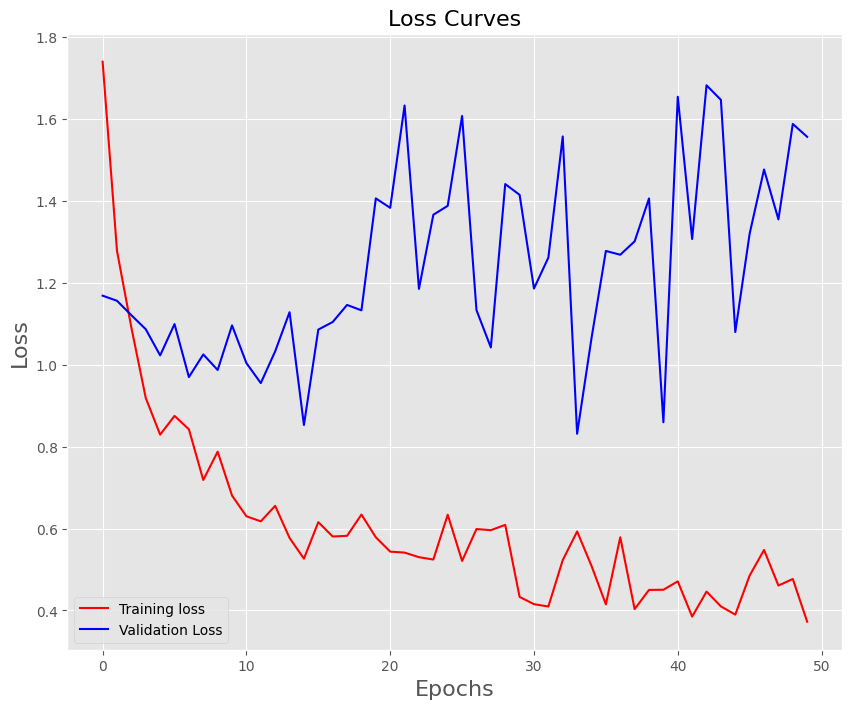

In [19]:
# loss curve（モデルの正確性を表す損失関数の学習過程における変化）の表示
plt.figure(figsize=[10,8]) #グラフの大きさを設定
plt.plot(model.history.history['loss'], 'r') #学習データの損失関数を赤色（'r'）で表示する
plt.plot(model.history.history['val_loss'], 'b') #検証データの損失関数を青色（'b'）で表示する
plt.legend(['Training loss', 'Validation Loss']) #グラフに反例を追加する
plt.xlabel('Epochs', fontsize=16) #横軸のラベルを設定する
plt.ylabel('Loss', fontsize=16) #縦軸のラベルを設定する
plt.title('Loss Curves', fontsize=16) #グラフのタイトルを設定する

#グラフを表示する
plt.show()

⭐️初学者向け次のコード解説
```
このコードは、モデルの「正確性（Accuracy）」が時間の経過とともにどう変化していったかを示すグラフを描くためのものです。

・赤い線（学習データの正確性）：モデルが学習する過程で、正解率がどう上がっていったかを示しています。
・青い線（検証データの正確性）：学習後、別のデータを使ってモデルがどれだけ正しく予測できたかを示しています。

このグラフは、モデルが学習を進めるにつれてどれだけ正確に問題を解けるようになったか、またその正確さが新しいデータに対しても
どのように変わっているかを確認するために使います。

＜理想のカーブ＞
・両方の線が徐々に増加：エポックが進むごとに、学習と検証の両方で正確性が上がるのが理想です。
・検証データの正確性が安定：ある時点で検証データの正確性（青い線）が横ばいになっても、それは自然なことです。
モデルがそのデータセットに対して最大の能力を発揮し、これ以上改善しない場合もあります。
```

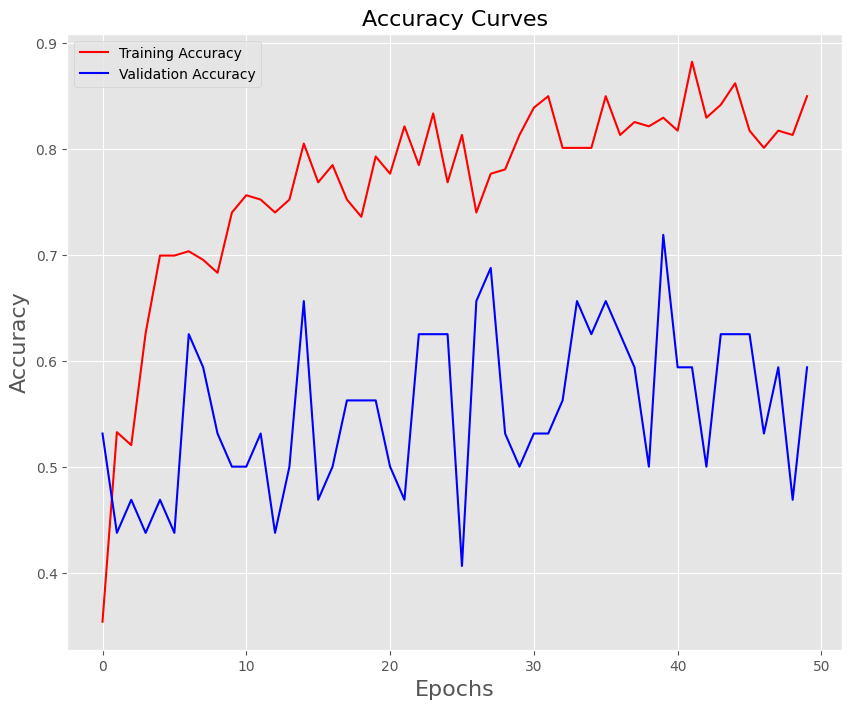

In [20]:
# accuracy curve（モデルの正確性の指標の学習過程における変化）の表示
plt.figure(figsize=[10,8])
plt.plot(model.history.history['accuracy'], 'r')
plt.plot(model.history.history['val_accuracy'], 'b')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

plt.show()

---
#####損失（モデルがどれだけ予測を間違えたか）の変化を表すグラフを表示しました。<br>赤い線で学習データ、青い線で確認用データの結果を示しています。<br>また、正確さの変化を表すグラフも表示し、学習データと確認用データの両方を比較しました。<br>これにより、どれだけうまく学習できているかがわかるようになりました。<br>次のセクションに進みましょう。
---

## 7. モデルによる判定
学習・検証用データに構築したモデルで良品、不良品の判定を行います。

In [21]:
# weightファイルの読み込み
print('load model...')
model.load_weights(save_weights_path)

load model...


🔔初学者向け次のコード解説
```
このコードは、モデルが画像を見て、その画像がどのクラス（カテゴリー）に属しているかを予測するためのものです。

何をするコードなのか？
目的:
コンピュータが画像の分類を予測し、その予測結果を本当の答え（クラス）と比べて、どれくらい正確に分類できたかを確認するための関数です。

使われるデータ:
学習用画像：コンピュータがすでに学習しているデータです。このデータで、クラス名がどう割り当てられているかを把握します。
テスト用画像：コンピュータがまだ見たことがない画像です。この画像を使って、コンピュータがどれだけ正しく予測できるかをテストします。

コードの流れとしては、
1.テスト用画像を読み込む準備をする
2.テスト用画像を1枚ずつ読み込む
3.モデルに画像を渡して予測する
4.予測結果からクラスを取り出す
5.クラス番号からクラス名を取得する
6.本当のクラス名を取得する
7.結果を返す
という一連の動作を行なっています。
```

In [22]:
# 良否判定を行うための関数
def get_predict(model,
                train_data_dir: str,
                test_data_dir: str):
    """この関数は、テスト用の画像データを使ってモデルの予測を行い、
    その結果をリストに保存する。

    Args:
        model (object): 訓練済みのモデル。
        train_data_dir (str): 学習用画像が保存されているフォルダのパス。
        test_data_dir (str): テスト用画像が保存されているフォルダのパス。

    Returns:
        filenames (list): 予測した画像のファイル名のリスト。
        true_classes (list): 予測した画像の本当のクラス（カテゴリー）のリスト。
        pred_classes (list): モデルが予測したクラス（カテゴリー）のリスト。
    """

    # テスト用画像を読み込み、モデルに入力するための準備をする
    # 画像の色の値を0から1の範囲に変換して扱いやすくする
    data_datagen = ImageDataGenerator()

    # テスト用の画像を一枚ずつ読み込んでモデルに渡す準備をする
    test_generator = data_datagen.flow_from_directory(
        test_data_dir,
        target_size=TARGET_SIZE,  # 画像の大きさを指定されたサイズに変更する
        class_mode=None,  # ラベル（正解）は指定しない
        batch_size=1,  # 一度に1枚の画像を処理する
        shuffle=False,  # 画像の順番をシャッフルしない（後でファイル名と予測結果を対応させるため）
    )

    # モデルにテスト用の画像を入力して、どのクラスに分類されるかを予測する
    preds = model.predict_generator(test_generator)

    # 予測結果から、一番高い確率で選ばれたクラスの番号を取り出す
    preds_class_idx = preds.argmax(axis=-1)

    # 予測したクラスの名前を取得するための準備
    # 学習用画像の情報を使って、クラス名（カテゴリー名）を取得する
    train_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
    )

    # モデルが使っている番号とクラス名（カテゴリー名）を対応させる辞書を作る
    idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
    # 予測されたクラスの番号をクラス名に変換する
    pred_classes = np.vectorize(idx_to_class.get)(preds_class_idx)
    # ファイル名と予測されたクラス名をペアにしたリストを作成する
    filenames_to_class = list(zip(test_generator.filenames, pred_classes))

    # 本当のクラス名（カテゴリー名）を取得するための準備
    filenames = []
    true_classes = []

    for item in test_generator.filenames:
        filenames.append(item)
        # ファイル名から本当のクラス名（カテゴリー名）を取り出す
        true_class = item.split('/')[0]
        true_classes.append(true_class)

    return filenames, true_classes, pred_classes

---
#####保存された重みファイルを読み込み、モデルに画像データを渡してその予測結果を取得する関数を定義しました。<br>画像を1枚ずつ読み込み、モデルに入力して分類を予測します。<br>予測結果は、ファイル名と対応させてリストに保存され、実際の答えとモデルが予測した答えを比較できるようにします。<br>これにより、モデルがどれだけ正確に画像を分類できるかを確認できます。<br>次のセクションに進みましょう。
---

🔔初学者向け次のコード解説
```
このコードは、コンピュータが「どれだけ正確に答えを予測できたか」を評価するために、
F1スコア、精度（Precision）、再現率（Recall）という3つの指標を計算する関数です。
これらの指標を使うと、モデルの予測がどれくらい優れているかがわかります。

F1スコア：予測の全体的なバランスを示す指標。精度と再現率のバランスが良いほどF1スコアが高くなります。
精度（Precision）：コンピュータが「正しい」と予測した中で、本当に正しかったものの割合。
再現率（Recall）：本当に正しかったものを、コンピュータがどれだけ正しく見つけたか。
```

In [23]:
# 精度算出関数（F1スコア、精度、再現率を計算する関数）
def get_f1(true_labels_list: list,
           predictions_list: list,
           average_method: str,
          ) -> (float, float, float):
    """この関数は、モデルの予測結果に基づいて、F1スコア、精度、再現率を計算する。

    Args:
        true_labels_list (list): 正解ラベルのリスト。
        predictions_list (list): 予測ラベルのリスト。
        average_method (string): スコアを平均化する方法（マルチクラス分類の場合）。

    Returns:
        f1 (float): F1スコアを返す。
        precision (float): 精度を返す。
        recall (float): 再現率を返す。
    """

    # F1スコアを計算する。F1スコアは精度と再現率のバランスをとる指標。
    f1 = f1_score(
        y_true=true_labels_list,  # 正解ラベルのリスト
        y_pred=predictions_list,  # 予測ラベルのリスト
        average=average_method    # 複数クラスの場合にどう平均化するかを指定
    )

    # 精度（Precision）を計算する。精度は、モデルが予測した「正しい」予測の割合を示す指標。
    precision = precision_score(
        y_true=true_labels_list,  # 正解ラベルのリスト
        y_pred=predictions_list,  # 予測ラベルのリスト
        average=average_method,   # 複数クラスの場合にどう平均化するかを指定
    )

    # 再現率（Recall）を計算する。再現率は、実際に正解であったものを、どれだけ正しく予測できたかを示す指標。
    recall = recall_score(
        y_true=true_labels_list,  # 正解ラベルのリスト
        y_pred=predictions_list,  # 予測ラベルのリスト
        average=average_method,   # 複数クラスの場合にどう平均化するかを指定
    )

    # 計算したF1スコア、精度、再現率を少数第2位まで丸める
    f1 = round(f1, 2)
    precision = round(precision, 2)
    recall = round(recall, 2)

    # F1スコア、精度、再現率を返す
    return f1, precision, recall

🔔初学者向け次のコード解説
```
このコードは、コンピュータがどれだけ正しく画像を分類できるかをテストしています。
まず、学習に使ったデータ（学習データ）で正しく予測できるかを見て、次に学習していない検証データで正しく予測できるかを確認します。
これにより、コンピュータが実際に新しいデータに対応できるかどうかをチェックしています。

get_predict関数を使って、学習データと検証データでコンピュータがどれくらい正しく予測できるかを確認しています。

このコードの結果について、
Found 290 images belonging to 4 classes:

これは、290枚の画像があって、それらが4つのクラスに分類されていることを示しています。コンピュータは、この290枚の画像を使って予測を行います。
4回同じメッセージ（Found 290 images belonging to 4 classes）が表示されているのは、
コンピュータが複数回にわたって同じ処理をしていることを示しています。
それぞれの処理の段階で、290枚の画像が4つのクラスに分類されていることを確認しているのです。
```

In [24]:
# 良否判定実行（学習データに対してモデルの予測を行う）
train_filenames, train_true_classes, train_pred_classes = get_predict(
    model=model,  # 使用するモデルを指定
    train_data_dir=train_data_dir,  # 学習データが保存されているフォルダのパスを指定
    test_data_dir=train_data_dir,  # 学習データをテストデータとして使用し、モデルの予測を実行
)

# 良否判定実行（検証データに対してモデルの予測を行う）
valid_filenames, valid_true_classes, valid_pred_classes = get_predict(
    model=model,  # 使用するモデルを指定
    train_data_dir=train_data_dir,  # 学習データが保存されているフォルダのパスを指定
    test_data_dir=validation_data_dir,  # 検証データをテストデータとして使用し、モデルの予測を実行
)

Found 290 images belonging to 4 classes.


<ipython-input-22-93f27d49ad7e>:33: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


Found 290 images belonging to 4 classes.
Found 290 images belonging to 4 classes.
Found 290 images belonging to 4 classes.


---
#####モデルの性能を評価するために、学習データと検証データに対して予測を行い、その結果を基にモデルの精度を測定しました。<br>後述するF1-scoreなどの指標を使って、モデルがどれだけ正確にデータを分類できているかの確認もしています。<br>最終的に、モデルの予測結果と実際の結果を比較し、モデルの性能を評価するための準備が整いました。<br>次のセクションに進みましょう。
---

## 8. 学習・検証データに対する精度評価
学習・検証データに対する精度をF1-score、Precision、Recallで評価します。

⭐️初学者向け解説（F1スコア / 精度（precision） / 再現率（recall））
```
このコードは、モデルの予測がどれくらい正確かをF1スコア、精度（precision）、再現率（recall）という3つの指標で評価しています。
まずは、これらの指標について簡単に説明します。

・F1スコア
F1スコアは、精度と再現率のバランスを取った指標です。どちらか一方が高くても、もう一方が低いとモデルの性能が十分ではないので、
両方のバランスを考慮して評価するのがF1スコアです。値が1に近いほど良いモデルを意味します。

・精度（precision）
精度は、モデルが「正しい」と予測したものの中で、本当に正しかったものの割合です。
たとえば、100回予測して50回「正しい」と予測したけど、そのうち40回が本当に正しかった場合、精度は40/50 = 80%です。

・再現率（recall）
再現率は、実際に正しいものの中で、モデルが「正しい」と予測できた割合です。
たとえば、実際には50回正しい答えがあったけど、モデルが40回しか正しく予測できなかった場合、再現率は40/50 = 80%です。
```

In [25]:
# 学習データに対する精度の算出（F1スコア、精度、再現率を計算）
train_f1, train_prec, train_recall = get_f1(
    true_labels_list=train_true_classes,  # 学習データの正解クラスのリストを指定
    predictions_list=train_pred_classes,  # 学習データに対するモデルの予測結果のリストを指定
    average_method='weighted',  # 各クラスの重要度に応じて平均を取る方法を指定（クラスの不均衡がある場合に有効）
)

# 検証データに対する精度の算出（F1スコア、精度、再現率を計算）
valid_f1, valid_prec, valid_recall = get_f1(
    true_labels_list=valid_true_classes,  # 検証データの正解クラスのリストを指定
    predictions_list=valid_pred_classes,  # 検証データに対するモデルの予測結果のリストを指定
    average_method='weighted',  # 各クラスの重要度に応じて平均を取る方法を指定（クラスの不均衡がある場合に有効）
)

🔔初学者向け次のコード解説
```
このコードは、左からそれぞれ前のコードで算出した学習データと検証データのF1スコア、精度、再現率を表示します。

表示する際に、数値を小数点以下2桁まででそろえて、学習データ（勉強したデータ）と検証データ（テストデータ）の結果が見やすくなるようにしています。
これにより、学習結果とテスト結果を簡単に比較できます。
```

In [26]:
# 精度表示
print('{:15}{:<15.2f}{:<15.2f}'.format('F1-score:', train_f1, valid_f1))
print('{:15}{:<15.2f}{:<15.2f}'.format('Precision:', train_prec, valid_prec))
print('{:15}{:<15.2f}{:<15.2f}'.format('Recall:', train_recall, valid_recall))

F1-score:      0.91           0.91           
Precision:     0.92           0.92           
Recall:        0.91           0.91           


---
#####学習データと検証データに対して、F1スコア、精度、再現率を計算し、それぞれの結果を表示しました。<br>これにより、モデルが学習データと検証データに対してどれだけ正確に予測できたかを比較することができ、<br>モデルのパフォーマンスを総合的に評価することができます。<br>次のセクションに進みましょう。
---

## 9. 提出ファイルの出力
テストデータに対して良否判定を行い、その結果を提出フォーマットであるtsv形式で出力を行います。

In [27]:
# Kerasの画像前処理ユーティリティをインポートする
# これにより、画像の読み込みやサイズ変更、データ拡張（オーギュメンテーション）などを簡単に行うことができる。
from keras.preprocessing import image

# ファイル名やパスのパターンマッチングを行うための標準ライブラリをインポートする
# 例えば、特定のフォルダ内のすべての画像ファイル（.jpgや.png）を取得したいときに便利。
import glob

In [28]:
# 分類とラベル（どの番号がどのクラスか）の対応を確認する
label_map = (train_generator.class_indices)
print(label_map)

{'bridge': 0, 'horn': 1, 'potato': 2, 'regular': 3}


In [29]:
# テストデータに対して1つずつ予測し、ファイル名と判定結果をリストに保存する
file_list = []  # 予測したファイル名を保存するリスト
pred_list = []  # 予測結果を保存するリスト

# テストデータのディレクトリ内のすべてのファイルに対して処理を行う
for file in glob.glob(test_data_dir + '/*'):
    image_data = file  # 現在処理しているファイルのパスを取得
    filename = file.split('/')[-1]  # ファイル名を取得（パスからファイル名だけを取り出す）

    # 画像を指定されたデータ形式に変換する
    img = image.load_img(image_data, target_size=(IMG_WIDTH, IMG_HEIGHT))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = x / 255

    # モデルを使って予測を行い、結果を取得する
    pred = model.predict(x)[0]

    # 予測結果の中で最も高い確率を持つクラス（ラベル）を選ぶ
    judge = np.argmax(pred)

    # 予測結果を良品（'0'）か不良（'1'）に変換する
    # *bridge, horn, potatoを不良（'1'）に、regularを良品（'0'）に変換する
    # この条件分岐は、前に確認した「分類とラベルの対応確認」セルの結果を参考にして調整する
    if judge == 0:
        judge = 1  # クラス0（例えばbridge）は不良品と判定
    elif judge == 1:
        judge = 1  # クラス1（例えばhorn）も不良品と判定
    elif judge == 2:
        judge = 1  # クラス2（例えばpotato）も不良品と判定
    else:
        judge = 0  # それ以外のクラス（例えばregular）は良品と判定

    # 判定結果とファイル名をそれぞれリストに追加する
    pred_list.append(judge)
    file_list.append(filename)

1/1 [==============================] - 0s 62ms/step


---
#####分類とラベルの対応を確認することで、モデルがどのクラスに対してどのラベルを使っているかを理解できました。<br>そして、テストデータの各画像に対して予測を行うことで、その画像が「良品」か「不良品」かを判断し、結果をリストに保存できました。
---

In [30]:
from datetime import datetime

now = datetime.now()

# ファイル名と予測結果をDataFrameに変換
#判別結果をDataFrameに変換し、tsvファイルに出力
df = pd.DataFrame([file_list, pred_list]).T
df.to_csv(f'/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver{now:%Y%m%d%H%M%S}.tsv',
         index=False,
         header=False,
         sep='\t')

---
#####予測結果が格納されたCSVファイルを「IDXXXXXX_PBL02_verXX.tsv」という名前で保存することができました。<br>ファイルを識別するためにファイル名を変更しておきましょう。<br>(例：ID123456_PBL02_ver1.tsv)<br>まだこれまでに一度も提出していない方は、こちらのファイルを一回目の投稿としてAIモデル精度評価サイトに提出しましょう。<br>
---

###AIモデル精度評価サイト　https://pbl-eval.life-is-tech.com/